# Module 3 : Enforcing explainability - A Custom Heuristic

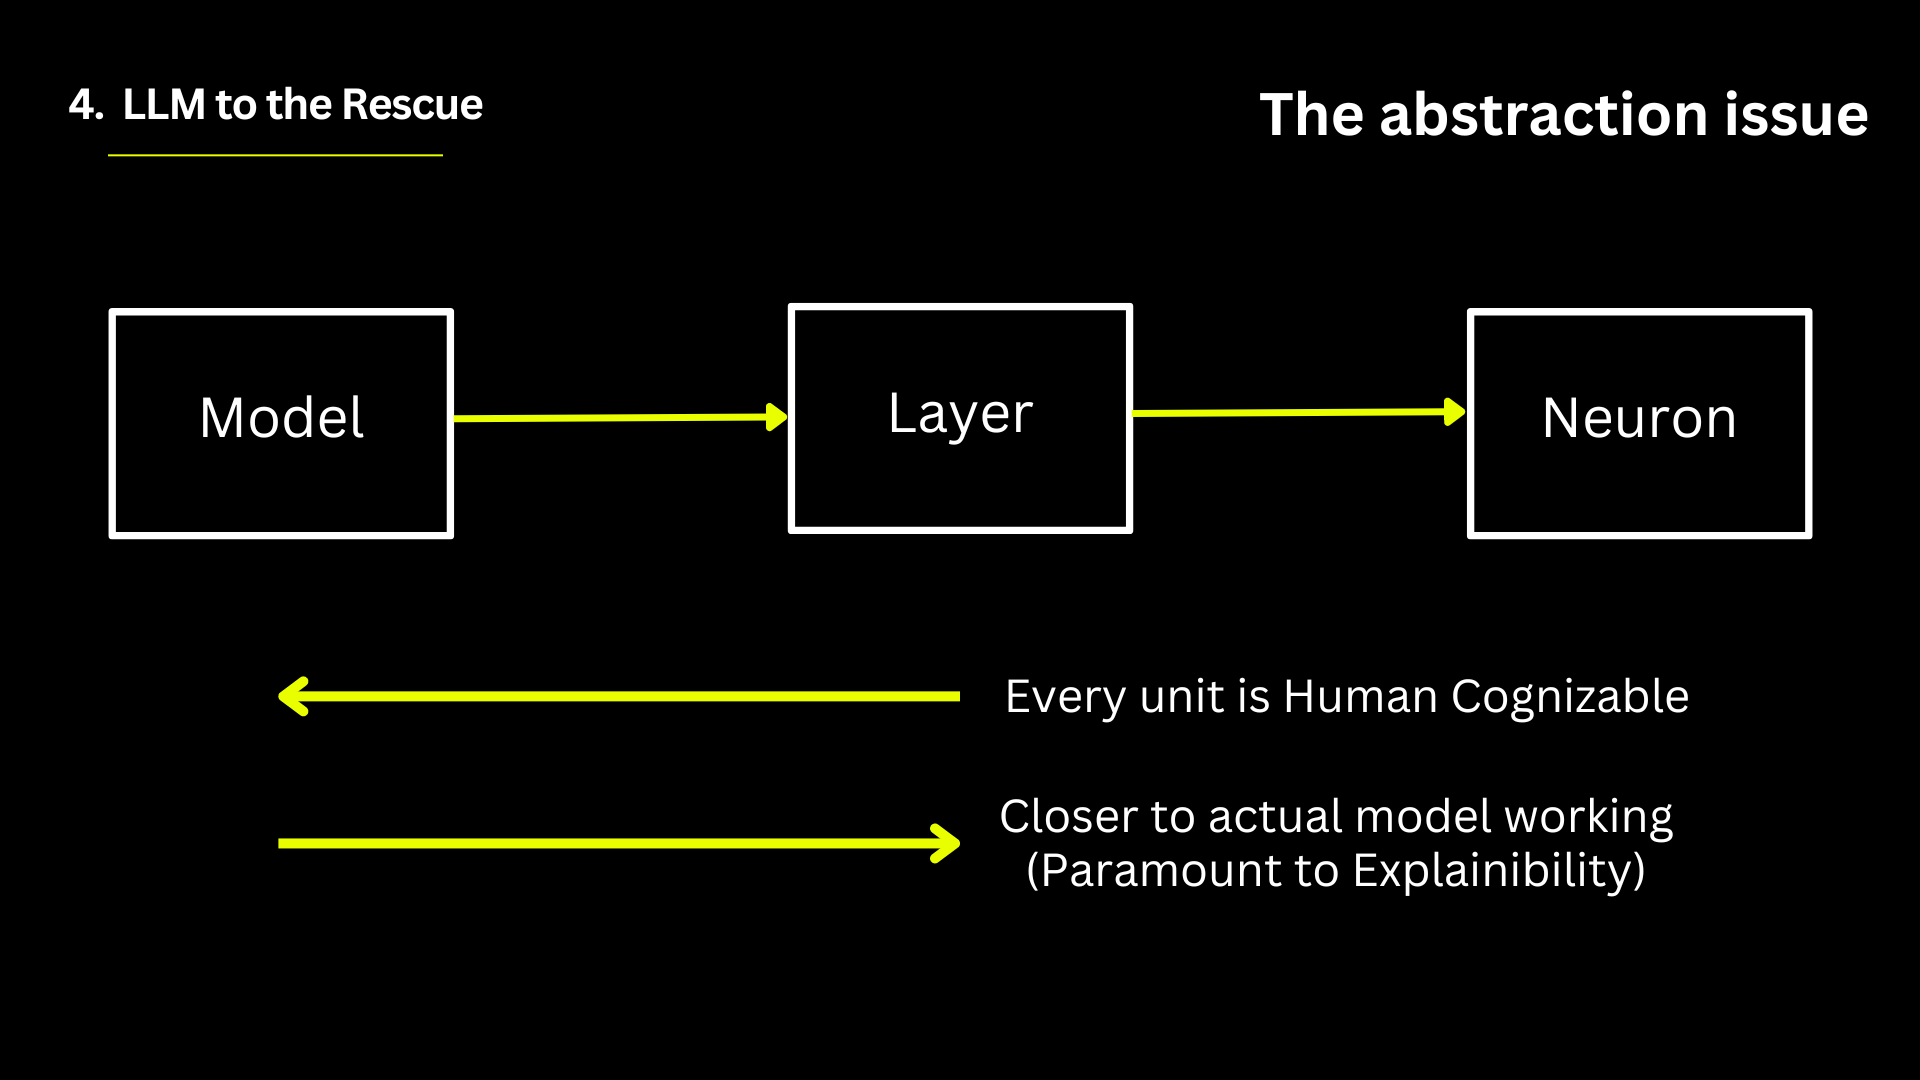

In [7]:
import PIL.Image
img = PIL.Image.open('images\\17.png')
img

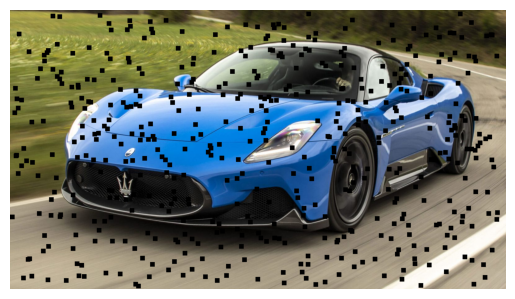

In [9]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the image
image = cv2.imread('images\im_bg.jpg')

# Get the shape of the image
height, width, _ = image.shape

# Define the size of the blacked out area
box_size = 15

# Randomly select the top-left corner of the blacked out area
for _ in range(500):  # Number of blackened parts
    x = np.random.randint(0, width - box_size)
    y = np.random.randint(0, height - box_size)

    # Black out the selected area
    image[y:y+box_size, x:x+box_size] = 0

# Save the resulting image
cv2.imwrite('bl.jpg', image)

plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

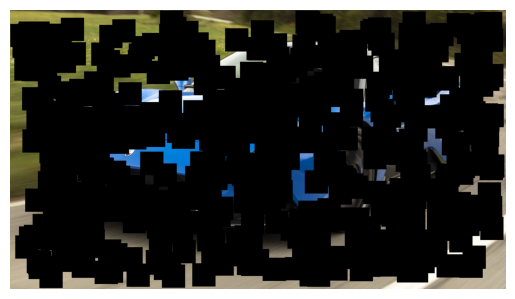

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the image
image = cv2.imread('im_bg.jpg')

# Get the shape of the image
height, width, _ = image.shape

# Define the size of the blacked out area
box_size = 75

# Randomly select the top-left corner of the blacked out area
for _ in range(500):  # Number of blackened parts
    x = np.random.randint(0, width - box_size)
    y = np.random.randint(0, height - box_size)

    # Black out the selected area
    image[y:y+box_size, x:x+box_size] = 0

# Save the resulting image
cv2.imwrite('bl.jpg', image)

plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

In [ ]:
import cv2
import numpy as np

def calculate_black_ratio(image_path):
  # Read the image in grayscale
  image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
  heatmap = image
  # print("min : ",np.min(heatmap))
  # print("max : ",np.max(heatmap))
  # print("heatmap shape :",heatmap.shape)
  # Convert the grayscale image to a binary image (black and white)
  # You might need to adjust the threshold value depending on your image
  thresh = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY)[1]
  # print(thresh)
  # Count the number of black pixels (0 in binary image)
  black_pixels = cv2.countNonZero(thresh)
  # print(black_pixels)
  # Get the total number of pixels (image height * width)
  total_pixels = image.shape[0] * image.shape[1]

  # Calculate the ratio of black pixels to total pixels (0.0 to 1.0)
  black_ratio = black_pixels / total_pixels

  return black_ratio

# Example usage
image_path = "im.jpg"
black_ratio = calculate_black_ratio(image_path)

print(f"Ratio of black pixels: {black_ratio}")


min :  0
max :  255
heatmap shape : (5304, 7952)
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
7074779
Ratio of black pixels: 0.16773859123822876


# Before the Custom Heuristic - less explainable neurons

In [11]:
import tensorflow as tf
import numpy as np
from keras import datasets, layers, models
import matplotlib.pyplot as plt
from keras.models import load_model

In [14]:
# Load CIFAR-10 dataset
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

# Define the selected classes
selected_classes = ['airplane', 'automobile', 'bird']

# Find indices of selected classes in CIFAR-10 classes
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
selected_indices = [class_names.index(class_name) for class_name in selected_classes]

# Filter the dataset to include only the selected classes
train_mask = [label[0] in selected_indices for label in train_labels]
test_mask = [label[0] in selected_indices for label in test_labels]

train_images = train_images[train_mask]
train_labels = train_labels[train_mask]

test_images = test_images[test_mask]
test_labels = test_labels[test_mask]

# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0

# Display sample images
#plt.figure(figsize=(10, 10))
image_count = 1

for i in range(len(train_labels)):
    # plt.subplot(5, 5, image_count)
    # plt.xticks([])
    # plt.yticks([])
    # plt.grid(False)
    #plt.imshow(train_images[i])

    # Map CIFAR-10 label to the selected class index
    label_index = selected_indices.index(train_labels[i][0])
    #plt.xlabel(selected_classes[label_index])

    image_count += 1

    if image_count > 25:  # Display only 25 images
        break

#plt.show()


In [25]:
model = load_model('model\cifar_cnn_gap_without.h5')

In [21]:
def plot_heatmaps_with_titles(heatmaps, size=(128,128), threshold_factor=0.5, boundary_color=(0, 0, 255)):
    num_heatmaps = len(heatmaps)
    num_rows = (num_heatmaps + 3) // 4
    num_cols = min(num_heatmaps, 4)

    fig, axs = plt.subplots(num_rows, num_cols, figsize=(16, 4 * num_rows))

    for i, heatmap in enumerate(heatmaps):
        if not isinstance(heatmap, np.ndarray):
            heatmap = np.array(heatmap)
        resized_heatmap = cv2.resize(heatmap, dsize=size, interpolation=cv2.INTER_CUBIC)


        threshold = 0.2 * np.max(resized_heatmap)
        mask = np.where(resized_heatmap > threshold, 1, 0)

        contours, _ = cv2.findContours(np.uint8(mask), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        for contour in contours:
            cv2.drawContours(resized_heatmap, [contour], -1, boundary_color, 1)

        if num_rows > 1:
            ax = axs[i // num_cols, i % num_cols]
        else:
            ax = axs[i % num_cols]

        ax.imshow(resized_heatmap , cmap= "gray")
        ax.set_title(f'Neuron {i + 1}')
        ax.axis('off')

    plt.tight_layout()
    plt.show()

In [22]:
from IPython.display import Image, display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import keras


last_conv_layer_name = "conv2d"
image = test_images[6]


def get_img_array(img):
    array = keras.utils.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name):
    grad_model = tf.keras.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.get_layer('global_average_pooling2d').output]
    )
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        num_neurons = preds.shape[1]

    heatmaps = []
    for class_index in range(num_neurons):

        with tf.GradientTape() as tape:
            last_conv_layer_output, preds = grad_model(img_array)
            class_channel = preds[:, class_index]
        grads = tape.gradient(class_channel, last_conv_layer_output)
        pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
        heatmap = tf.reduce_sum(last_conv_layer_output[0] * pooled_grads, axis=-1)
        heatmaps.append(heatmap)

    return heatmaps

(1, 32, 32, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Predicted: [[-1.2027543 -3.680608   6.9940476]]


ValueError: No such layer: conv2d_6. Existing layers are: ['conv2d', 'max_pooling2d', 'conv2d_1', 'max_pooling2d_1', 'conv2d_2', 'global_average_pooling2d', 'dense'].

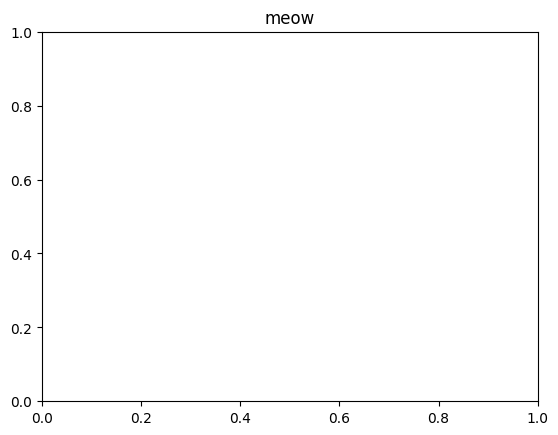

In [23]:
import cv2
import numpy as np

last_layer = 'conv2d'  # Choose the last convolutional layer

img_array = test_images[16]
img_array = np.expand_dims(img_array, axis=0)
print(img_array.shape)

preds = model.predict(img_array)
print("Predicted:", preds)
# Get the class activation map (CAM) for the image
plt.title('meow')
heatmaps = make_gradcam_heatmap( img_array,model, last_layer)
plot_heatmaps_with_titles(heatmaps)

# Innovating a new loss function

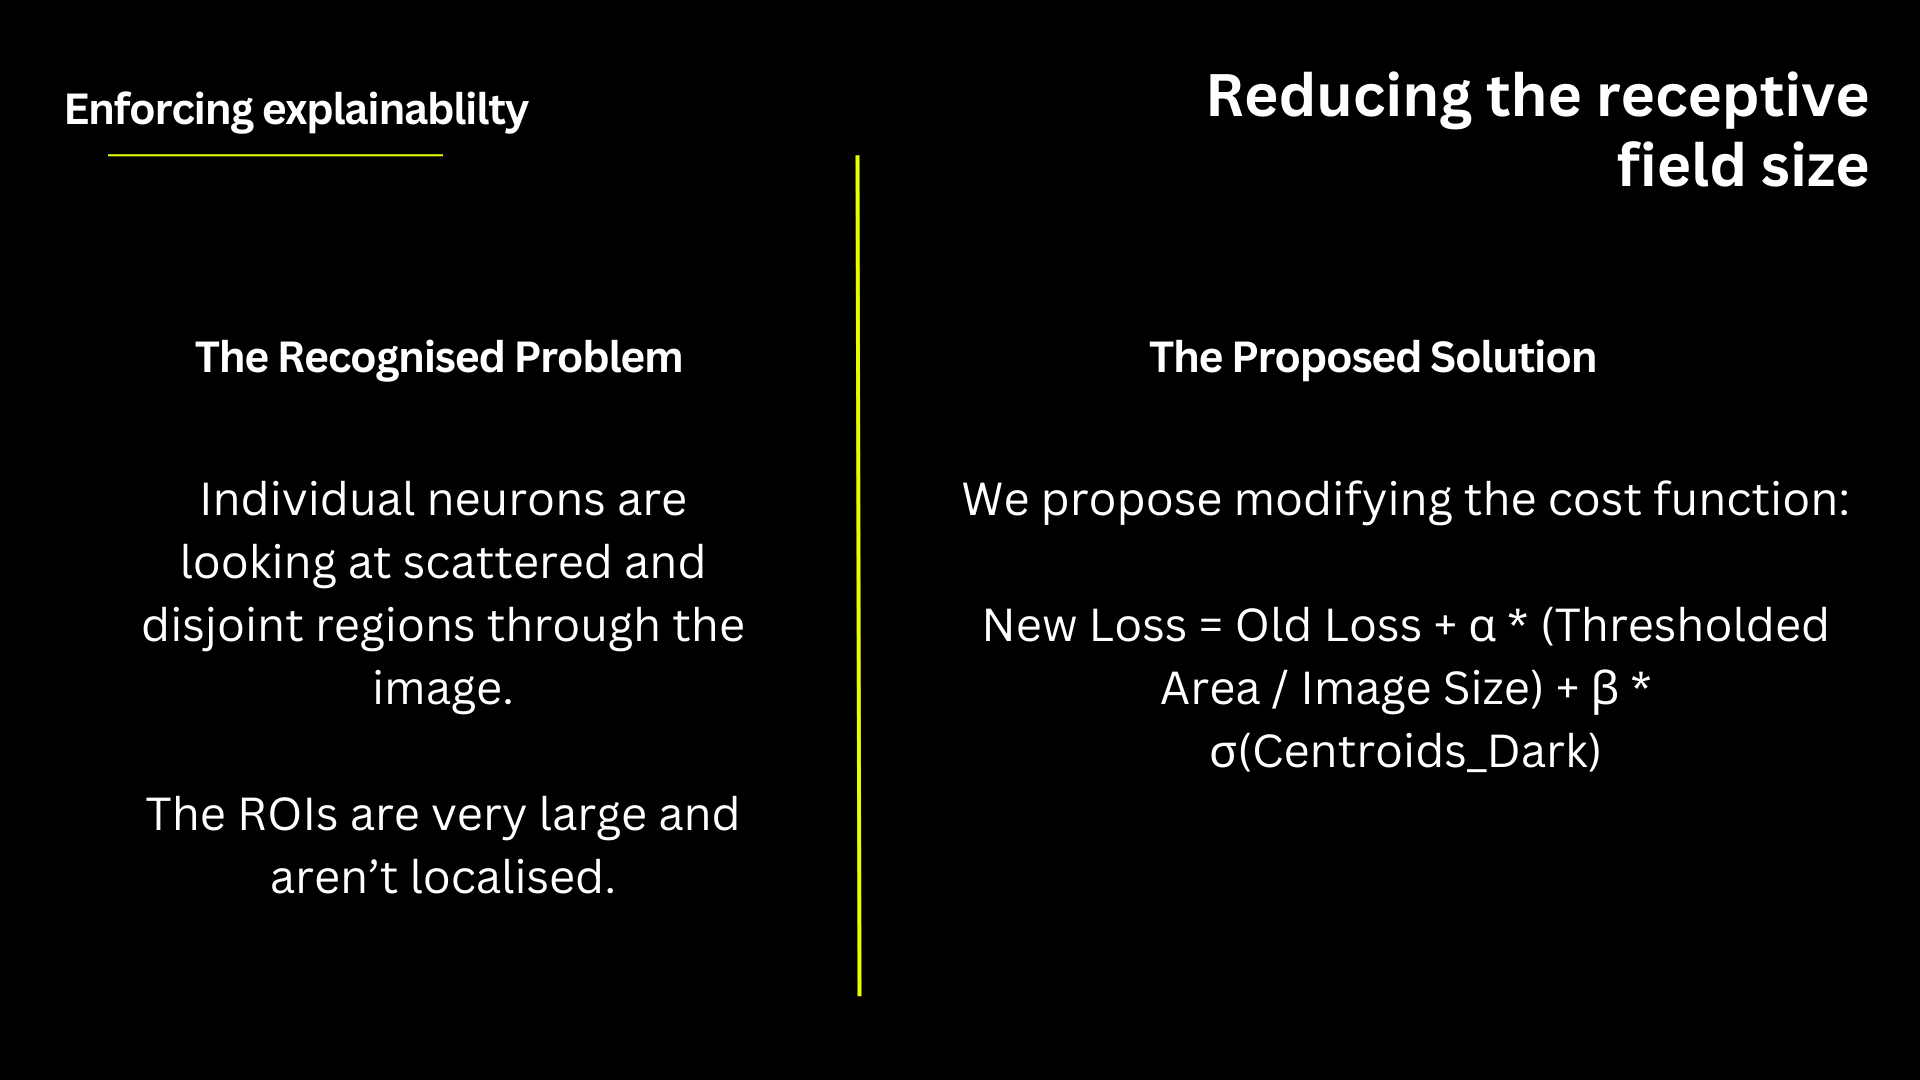

In [ ]:
def custom_loss(y_true, y_pred, weight_black_ratio=0.1):
  categorical_loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)(y_true, y_pred)
  black_ratios = plot_heatmaps_with_titles_black(heatmaps)
  average_black_ratio = tf.reduce_mean(black_ratios)
  custom_loss_value = categorical_loss + weight_black_ratio * average_black_ratio

  return custom_loss_value

def calculate_black_ratio(image):
  grayscale = image
  min_val = np.min(grayscale)
  max_val = np.max(grayscale)
  if min_val != max_val:
    grayscale = (grayscale - min_val) * (255.0 / (max_val - min_val))
  grayscale = grayscale.astype(np.uint8)
  thresh = cv2.threshold(grayscale, 127, 255, cv2.THRESH_BINARY)[1]
  black_pixels = cv2.countNonZero(thresh)
  total_pixels = image.shape[0] * image.shape[1]
  black_ratio = black_pixels / total_pixels

  return black_ratio

In [ ]:
from keras.models import load_model
model = load_model('/content/cifar_cnn_gap_cost2.h5', custom_objects={'custom_loss': custom_loss })
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 15, 15, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 6, 6, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 4, 4, 64)          36928     
                                                                 
 global_average_pooling2d_2  (None, 64)               

In [ ]:
from IPython.display import Image, display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import keras


last_conv_layer_name = "conv2d_6"
image = test_images[6]


def get_img_array(img):
    array = keras.utils.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name):
    grad_model = tf.keras.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.get_layer('global_average_pooling2d_2').output]
    )
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        num_neurons = preds.shape[1]

    heatmaps = []
    for class_index in range(num_neurons):

        with tf.GradientTape() as tape:
            last_conv_layer_output, preds = grad_model(img_array)
            class_channel = preds[:, class_index]
        grads = tape.gradient(class_channel, last_conv_layer_output)
        pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
        heatmap = tf.reduce_sum(last_conv_layer_output[0] * pooled_grads, axis=-1)
        heatmaps.append(heatmap)

    return heatmaps

In [ ]:
last_layer = 'conv2d_6'  # Choose the last convolutional layer

img_array = test_images[16]
img_array = np.expand_dims(img_array, axis=0)
print(img_array.shape)
heatmaps = make_gradcam_heatmap( img_array,model, last_layer)

(1, 32, 32, 3)


# ROIs with our new loss function

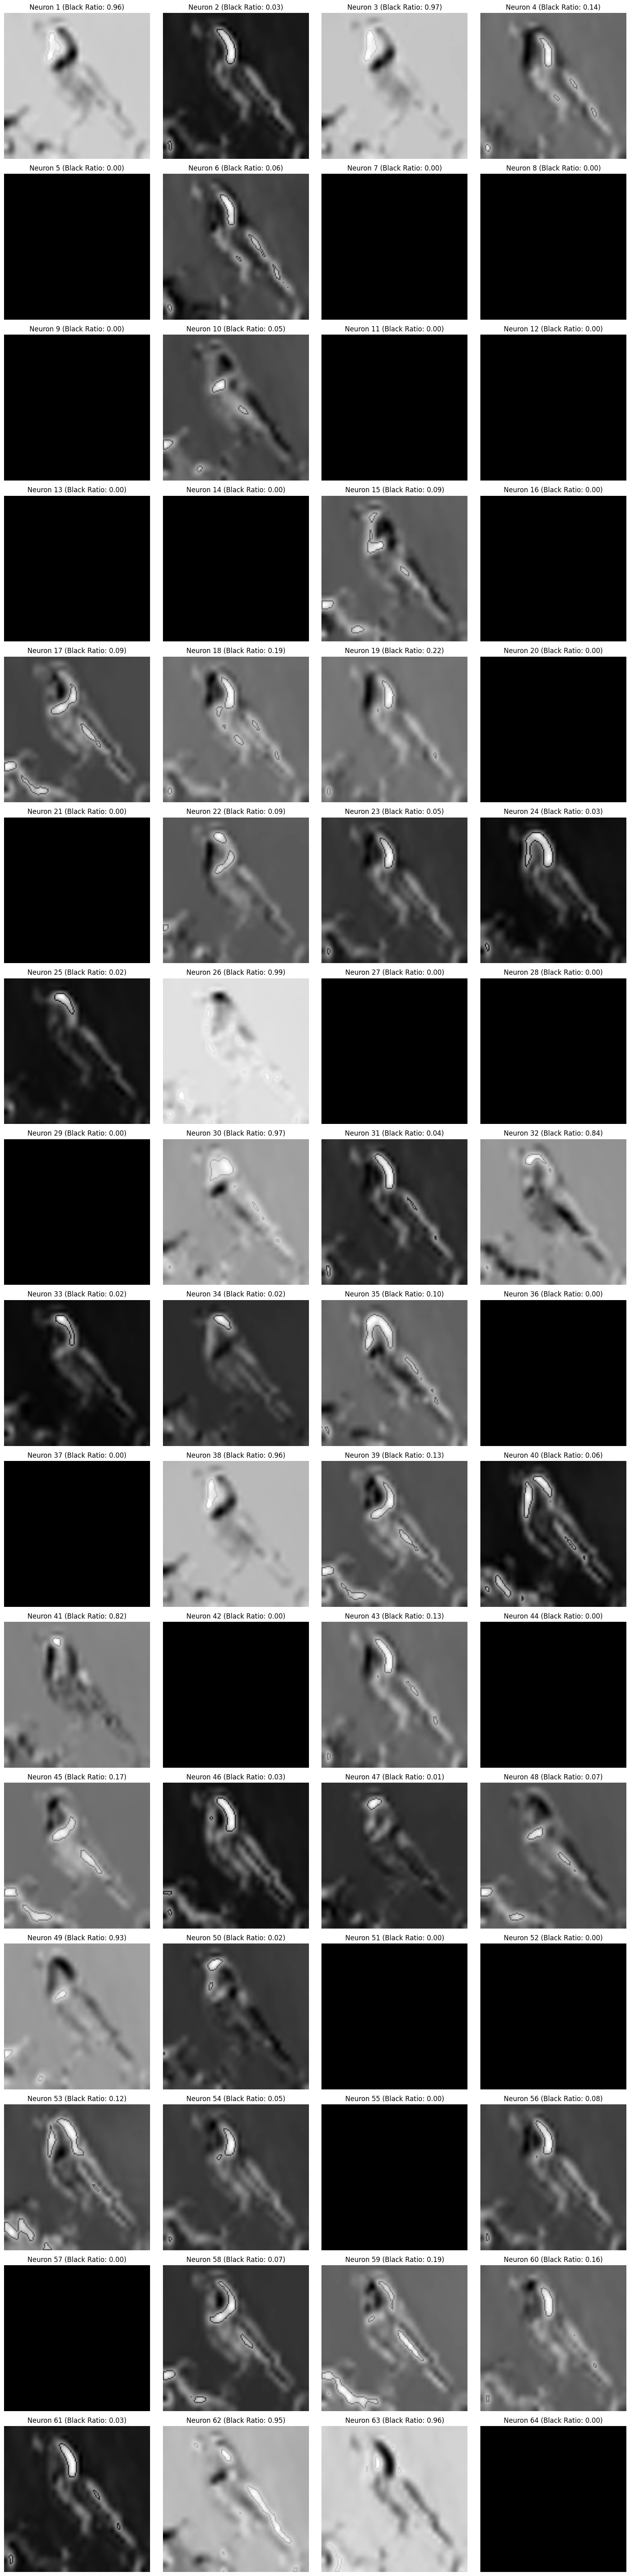

[0.9588888888888889,
 0.027777777777777776,
 0.9711111111111111,
 0.14444444444444443,
 0.0,
 0.057777777777777775,
 0.0,
 0.0,
 0.0,
 0.04777777777777778,
 0.0,
 0.0,
 0.0,
 0.0,
 0.09111111111111111,
 0.0,
 0.09333333333333334,
 0.18777777777777777,
 0.22,
 0.0,
 0.0,
 0.09222222222222222,
 0.05,
 0.034444444444444444,
 0.016666666666666666,
 0.9922222222222222,
 0.0,
 0.0,
 0.0,
 0.9688888888888889,
 0.04111111111111111,
 0.8388888888888889,
 0.01888888888888889,
 0.016666666666666666,
 0.09666666666666666,
 0.0,
 0.0,
 0.9555555555555556,
 0.1288888888888889,
 0.057777777777777775,
 0.8155555555555556,
 0.0,
 0.12777777777777777,
 0.0,
 0.16555555555555557,
 0.03333333333333333,
 0.014444444444444444,
 0.06777777777777778,
 0.9266666666666666,
 0.021111111111111112,
 0.0,
 0.0,
 0.11555555555555555,
 0.04666666666666667,
 0.0,
 0.07555555555555556,
 0.0,
 0.07333333333333333,
 0.19444444444444445,
 0.15666666666666668,
 0.027777777777777776,
 0.9533333333333334,
 0.9566666666666667

In [ ]:
import cv2

def plot_heatmaps_with_titles_black(heatmaps, size=(128, 128), threshold_factor=0.5, boundary_color=(0, 0, 255)):
  num_heatmaps = len(heatmaps)
  num_rows = (num_heatmaps + 3) // 4
  num_cols = min(num_heatmaps, 4)

  fig, axs = plt.subplots(num_rows, num_cols, figsize=(16, 4 * num_rows))

  black_ratios = []

  for i, heatmap in enumerate(heatmaps):
    if not isinstance(heatmap, np.ndarray):
      heatmap = np.array(heatmap)
    resized_heatmap = cv2.resize(heatmap, dsize=size, interpolation=cv2.INTER_CUBIC)

    threshold = threshold_factor * np.max(resized_heatmap)
    mask = np.where(resized_heatmap > threshold, 1, 0)

    contours, _ = cv2.findContours(np.uint8(mask), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    for contour in contours:
      cv2.drawContours(resized_heatmap, [contour], -1, boundary_color, 1)

    if num_rows > 1:
      ax = axs[i // num_cols, i % num_cols]
    else:
      ax = axs[i % num_cols]

    ax.imshow(resized_heatmap, cmap="gray")
    # Calculate black ratio using the separate function
    # print("min : ",np.min(heatmap))
    # print("max : ",np.max(heatmap))
    # print("heatmap shape :",heatmap.shape)
    black_ratio = calculate_black_ratio(heatmap)
    black_ratios.append(black_ratio)

    ax.set_title(f'Neuron {i + 1} (Black Ratio: {black_ratio:.2f})')

    ax.axis('off')

  plt.tight_layout()
  plt.show()
  return black_ratios

plot_heatmaps_with_titles_black(heatmaps)